# HW3 on Data Science course of Sharif University of Technology
## Created by: Mohammad Mahdi Hossein Beiky     SI: 400100995
## GitHub URL: https://github.com/Mmhb1382/data-science.git
---

### Import python packages here:

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

In [64]:
# Load dataset
df = pd.read_csv("achare.csv")
df.head()

,No. Previous Orders by Customer,Customer Join Date,Parent Service Category,Service Name,Order Status,Order City,Order Region,Workman Joine Date,Desired Date,Creation Date,Finish Date,Customer Rating,workman Rating Score,Comment,Device,Price,Discount,Quoted Task?
0,3,1396-06-09 11:51:32.505950+04:30,نظافت و پذیرایی,نظافت راه‌ پله,ثبت‌ شده,تهران,استاد معین,NaN,1400-06-26 10:00:01.000000+04:30,1400-06-24 03:06:56.093221+04:30,1400-06-26 16:00:01.000000+04:30,NaN,NaN,NaN,android,180000,0,AUTOMATIC_ALLOCATION
1,0,1400-06-24 02:54:34.549933+04:30,دکوراسیون و بازسازی,بنایی,Achar_Pending,تهران,وردآورد,NaN,1400-06-24 09:30:01.000000+04:30,1400-06-24 03:03:12.365980+04:30,1400-06-24 10:30:01.000000+04:30,NaN,NaN,NaN,android,0,0,MANUAL_ALLOCATION
2,0,1400-06-24 02:46:15.891303+04:30,نصب و تعمیر لوازم خانگی,نصب و تعمیر یخچال و فریزر,ثبت‌ شده,رشت,پل طالشان,NaN,1400-06-25 12:30:01.000000+04:30,1400-06-24 02:59:20.374623+04:30,1400-06-25 13:30:01.000000+04:30,NaN,NaN,NaN,android,0,0,MANUAL_ALLOCATION
3,0,1397-03-16 14:28:00.764511+04:30,تعمیرات خودرو,صافکاری و نقاشی,ثبت‌ شده,رشت,فلکه جهاد,NaN,1400-06-24 09:00:01.000000+04:30,1400-06-24 02:42:10.924776+04:30,1400-06-24 10:00:01.000000+04:30,NaN,NaN,NaN,android,0,0,MANUAL_ALLOCATION
4,0,1400-06-24 02:26:08.327191+04:30,دکوراسیون و بازسازی,بنایی,لغو شده,تهران,ستارخان,NaN,1400-06-24 09:30:01.000000+04:30,1400-06-24 02:37:03.244927+04:30,1400-06-24 10:30:01.000000+04:30,NaN,NaN,NaN,android,0,0,MANUAL_ALLOCATION


In [65]:
### 1. Handling Missing Values ###
# Drop columns if too many missing values (e.g., more than 90%)
thresh = len(df) * 0.9
df = df.dropna(thresh=thresh, axis=1)

In [66]:
# Fill missing categorical values with the most frequent value
df.fillna({col: df[col].mode()[0] for col in df.select_dtypes(include=['object']).columns}, inplace=True)

In [67]:
# Fill missing numerical values with median
df.fillna({col: df[col].median() for col in df.select_dtypes(include=['int64', 'float64']).columns}, inplace=True)

In [68]:
### 2. Handling Duplicates ###
df.drop_duplicates(inplace=True)

In [69]:
### 3. Handling Outliers ###
def remove_outliers(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Apply outlier removal on numerical columns
df = remove_outliers(df, df.select_dtypes(include=['int64', 'float64']).columns)

In [70]:
### 4. Encoding Categorical Data ###
# Label Encoding for specific multi-class categorical variables
label_encoders = {}
label_encoding_cols = ['Parent Service Category', 'Service Name', 'Order Status', 'Order City', 'Order Region']
for col in label_encoding_cols:
    le = LabelEncoder()
    df.insert(df.columns.get_loc(col) + 1, f'{col}_Encoded', le.fit_transform(df[col]))
    label_encoders[col] = le

In [71]:
# One-Hot Encoding for categorical variables with a few unique values
one_hot_cols = [col for col in df.select_dtypes(include=['object']).columns if df[col].nunique() <= 10 and col not in label_encoding_cols]
for col in one_hot_cols:
    one_hot = pd.get_dummies(df[col], prefix=col).astype(int)
    col_index = df.columns.get_loc(col) + 1
    for new_col in one_hot.columns[::-1]:  # Reverse to keep order correct when inserting
        df.insert(col_index, new_col, one_hot[new_col])

In [72]:
### 5. Handling Hijri Shamsi Dates Properly ###
date_cols = ['Customer Join Date', 'Desired Date', 'Creation Date', 'Finish Date']

def extract_shamsi_date_parts(date_str):
    try:
        parts = date_str.split(" ")[0].split("-")  # Extract YYYY-MM-DD part
        if len(parts) == 3:
            year, month, day = map(int, parts)
            return year, month, day
    except:
        return None, None, None
    return None, None, None

for col in date_cols:
    extracted_dates = df[col].astype(str).apply(extract_shamsi_date_parts)
    df.insert(df.columns.get_loc(col) + 1, f'{col}_Year', extracted_dates.apply(lambda x: x[0]))
    df.insert(df.columns.get_loc(col) + 2, f'{col}_Month', extracted_dates.apply(lambda x: x[1]))
    df.insert(df.columns.get_loc(col) + 3, f'{col}_Day', extracted_dates.apply(lambda x: x[2]))

In [73]:
### 6. Normalization & Standardization ###
# Exclude label-encoded and datetime columns from normalization
excluded_cols = label_encoding_cols + [f'{col}_Encoded' for col in label_encoding_cols] + date_cols + [f'{col}_Year' for col in date_cols] + [f'{col}_Month' for col in date_cols] + [f'{col}_Day' for col in date_cols] + [f'{col}_Hour' for col in date_cols] + [f'{col}_Minute' for col in date_cols] + [f'{col}_Second' for col in date_cols]
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in excluded_cols]
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [74]:
df

,No. Previous Orders by Customer,Customer Join Date,Customer Join Date_Year,Customer Join Date_Month,Customer Join Date_Day,Parent Service Category,Parent Service Category_Encoded,Service Name,Service Name_Encoded,Order Status,...,Device,Device_android,Device_ios,Device_web,Price,Discount,Quoted Task?,Quoted Task?_AUTOMATIC_ALLOCATION,Quoted Task?_FAVORITE_ALLOCATION,Quoted Task?_MANUAL_ALLOCATION
0,0.130435,1396-06-09 11:51:32.505950+04:30,1396,6,9,نظافت و پذیرایی,25,نظافت راه‌ پله,194,ثبت‌ شده,...,android,1.0,0.0,0.0,0.400000,0.0,AUTOMATIC_ALLOCATION,1.0,0.0,0.0
1,0.000000,1400-06-24 02:54:34.549933+04:30,1400,6,24,دکوراسیون و بازسازی,17,بنایی,33,Achar_Pending,...,android,1.0,0.0,0.0,0.000000,0.0,MANUAL_ALLOCATION,0.0,0.0,1.0
2,0.000000,1400-06-24 02:46:15.891303+04:30,1400,6,24,نصب و تعمیر لوازم خانگی,24,نصب و تعمیر یخچال و فریزر,188,ثبت‌ شده,...,android,1.0,0.0,0.0,0.000000,0.0,MANUAL_ALLOCATION,0.0,0.0,1.0
3,0.000000,1397-03-16 14:28:00.764511+04:30,1397,3,16,تعمیرات خودرو,8,صافکاری و نقاشی,133,ثبت‌ شده,...,android,1.0,0.0,0.0,0.000000,0.0,MANUAL_ALLOCATION,0.0,0.0,1.0
4,0.000000,1400-06-24 02:26:08.327191+04:30,1400,6,24,دکوراسیون و بازسازی,17,بنایی,33,لغو شده,...,android,1.0,0.0,0.0,0.000000,0.0,MANUAL_ALLOCATION,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15348,0.217391,1397-12-20 08:14:12.107241+03:30,1397,12,20,دکوراسیون و بازسازی,17,تعمیر و نصب کابینت,62,پیدا نشد,...,android,1.0,0.0,0.0,0.000000,0.0,AUTOMATIC_ALLOCATION,1.0,0.0,0.0
15349,0.086957,1399-03-12 09:02:46.650380+04:30,1399,3,12,دکوراسیون و بازسازی,17,بنایی,33,پیدا نشد,...,web,0.0,0.0,1.0,0.000000,0.0,MANUAL_ALLOCATION,0.0,0.0,1.0
15350,0.086957,1399-03-11 11:54:27.008224+04:30,1399,3,11,نظافت و پذیرایی,25,خدمات عادی نظافت,89,پیدا نشد,...,web,0.0,0.0,1.0,0.177778,0.0,AUTOMATIC_ALLOCATION,1.0,0.0,0.0
15351,0.304348,1398-09-04 19:35:23.226869+03:30,1398,9,4,شستشو,20,قالیشویی,145,پیدا نشد,...,android,1.0,0.0,0.0,0.000000,0.0,MANUAL_ALLOCATION,0.0,0.0,1.0


### Pie Chart of Order Status Distribution
This pie chart shows the proportion of different order statuses in the dataset, helping to understand the frequency of cancellations, completed orders, and other statuses.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 108 (l) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 112 (p) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 99 (c) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 111 (o) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 117 (u) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 110 (n) missing from font(s) B Nazanin.

c:\Us

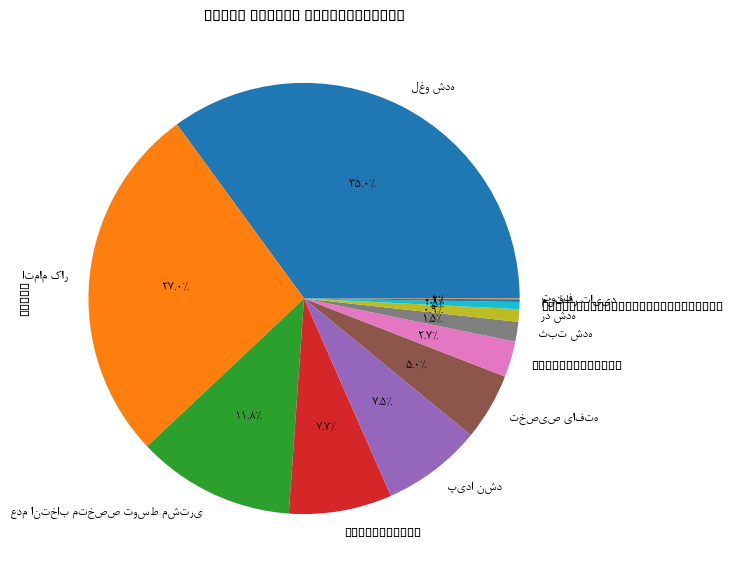

In [75]:
plt.figure(figsize=(7,7))
df['Order Status'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Order Status Distribution')
plt.show()

### Box Plot of Normalized Features
Box plots help identify the distribution and outliers of the numeric features after normalization.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 108 (l) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 112 (p) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 66 (B) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 111 (o) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 120 (x) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 116 (t) missing from font(s) B Nazanin.

c:\Us

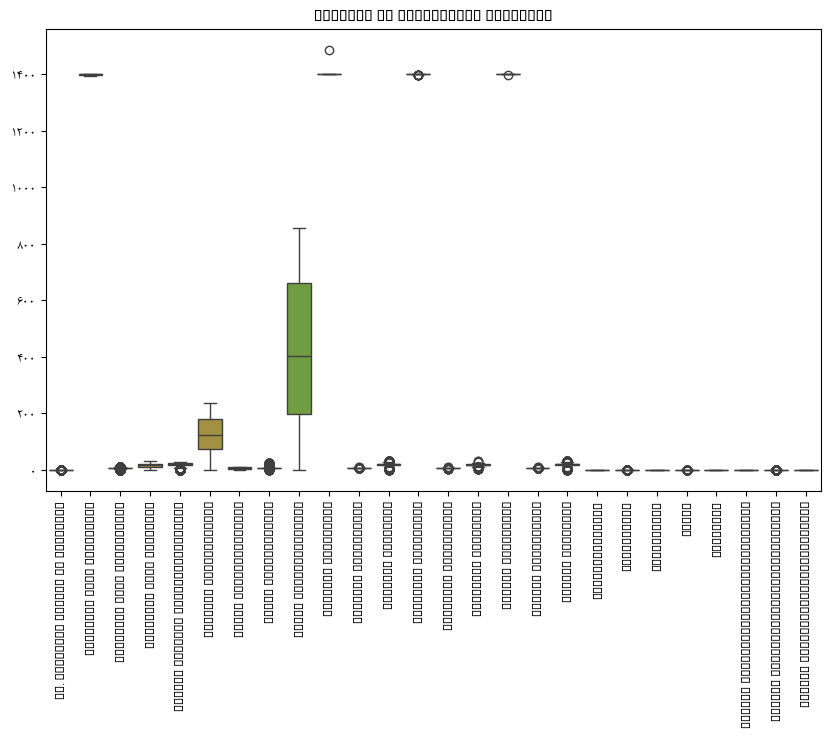

In [76]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Boxplot of Normalized Features')
plt.show()

### Line Chart of Prices Over Time
A simple line chart to visualize price trends over time.

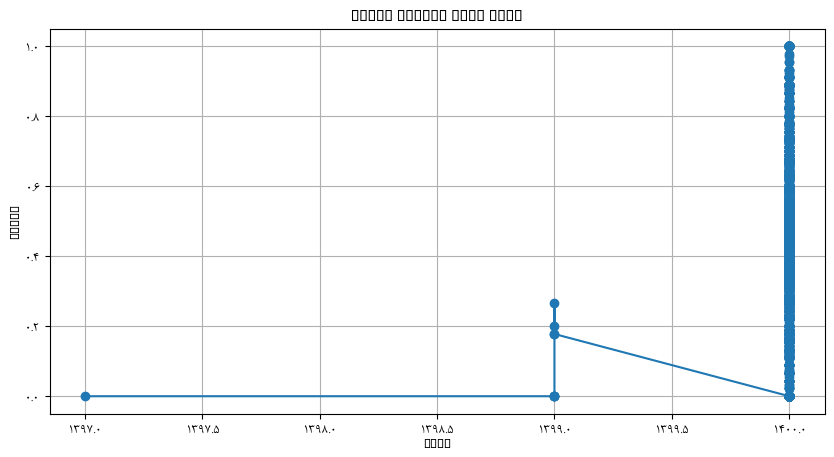

In [77]:
plt.figure(figsize=(10, 5))
df_sorted = df.sort_values(by='Creation Date_Year')
plt.plot(df_sorted['Creation Date_Year'], df_sorted['Price'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Price Trends Over Time')
plt.grid()
plt.show()

### Bar Chart of Orders per City
This bar chart displays the number of orders from different cities.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 108 (l) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 112 (p) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 78 (N) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 117 (u) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 109 (m) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 98 (b) missing from font(s) B Nazanin.

c:\Use

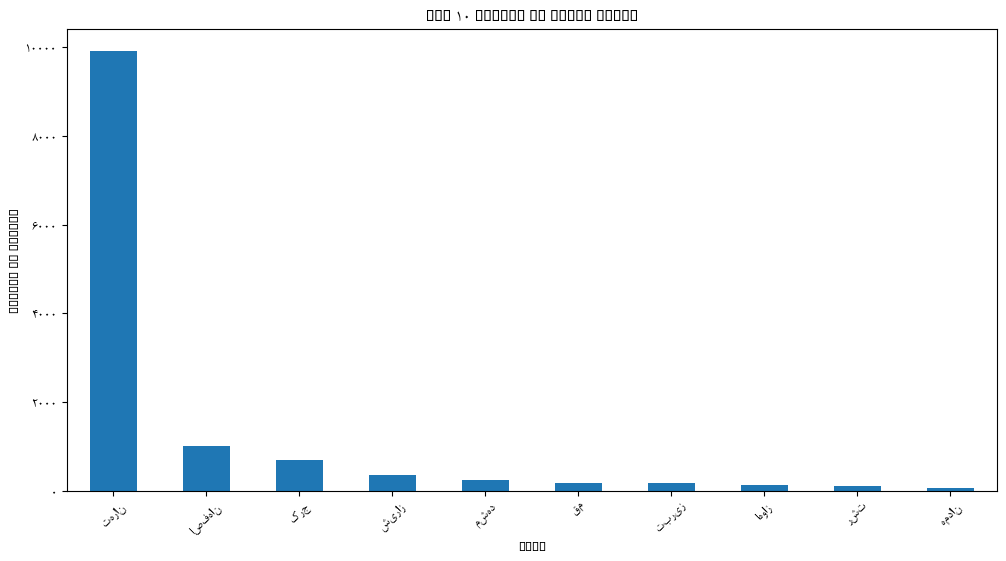

In [78]:
plt.figure(figsize=(12, 6))
df['Order City'].value_counts().head(10).plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Number of Orders')
plt.title('Top 10 Cities by Order Count')
plt.xticks(rotation=45)
plt.show()

### Scatter Plot of Price vs. Discount
This scatter plot helps visualize any correlation between price and discounts offered.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 108 (l) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 112 (p) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 68 (D) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 105 (i) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 115 (s) missing from font(s) B N

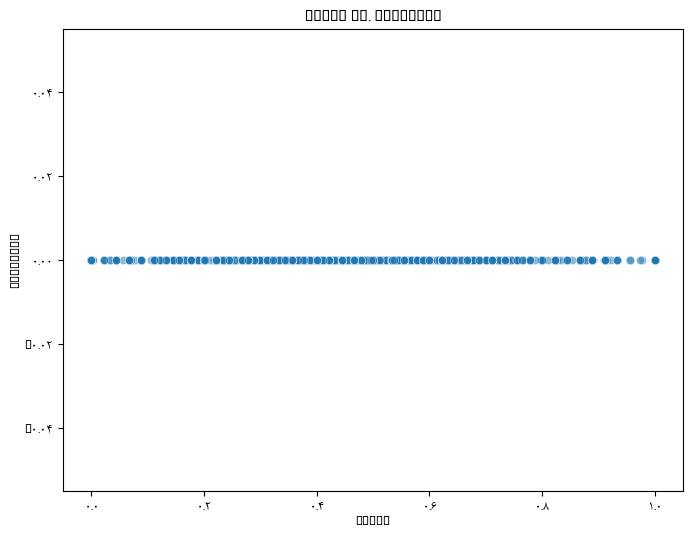

In [79]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Price'], y=df['Discount'], alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Discount')
plt.title('Price vs. Discount')
plt.show()

### Error Bar Chart: Average Price per Year with Variability
This chart displays the mean price per year with error bars showing the standard deviation.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 65 (A) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 97 (a) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 103 (g) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 89 (Y) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 119 (w) missing from font(s) B Nazanin.

c:\Users\SARIR\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 104 (h) missing from font(s) B Nazanin.

c:\User

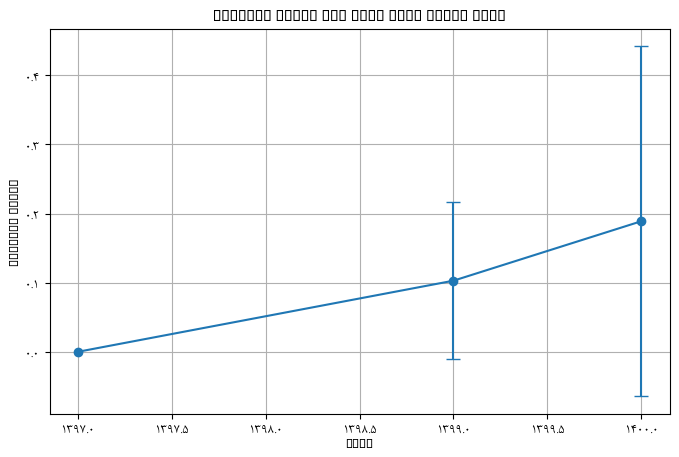

In [80]:
grouped = df.groupby('Creation Date_Year')['Price'].agg(['mean', 'std'])
plt.figure(figsize=(8,5))
plt.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], fmt='o-', capsize=5)
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.title('Average Price per Year with Error Bars')
plt.grid()
plt.show()

### Interactive Histogram of Prices
This interactive histogram allows users to explore the price distribution dynamically.

In [81]:
fig = px.histogram(df, x='Price', title='Price Distribution', nbins=30)
fig.show()